1. Data initialization

In [3]:
import os
import pandas as pd
import numpy as np
from featurewiz import featurewiz
from matplotlib import pyplot as plt
from featurewiz import featurewiz
import json


folder = os.path.join("/", "RanD", "CREMEv2_Result", "20230310", "logs_working", "label_accounting")

if os.path.exists(folder):
    print("Path is exist!!!")
    filename_label = 'label_accounting.csv'
    filename_ready = 'label_accounting_ready_lifecycle.csv'
    filename_train = 'label_accounting_train_lifecycle.csv'
    label_technique = 'labels_technique.json'
    label_lifecycle = 'labels_lifecycle.json'
else:
    print("Path is not exist!!!")

Imported 0.2.04 version. Select nrows to a small number when running on huge datasets.
output = featurewiz(dataname, target, corr_limit=0.90, verbose=2, sep=',', 
		header=0, test_data='',feature_engg='', category_encoders='',
		dask_xgboost_flag=False, nrows=None, skip_sulov=False)
Create new features via 'feature_engg' flag : ['interactions','groupby','target']

Path is exist!!!


2. Data processing and feature selection

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.7 as the correlation limit. Change this limit to fit your needs...
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Multi_Classification problem ####
    Caution: We will try to reduce the memory usage of dataframe from 1538.54 MB
        memory usage after optimization is: 305.96 MB
        decreased by 80.1%
    Loaded train data. Shape = (4583180, 44)
    Some column names had special characters which were removed...
#### Single_Label Multi_Classification problem ####
No test data filename

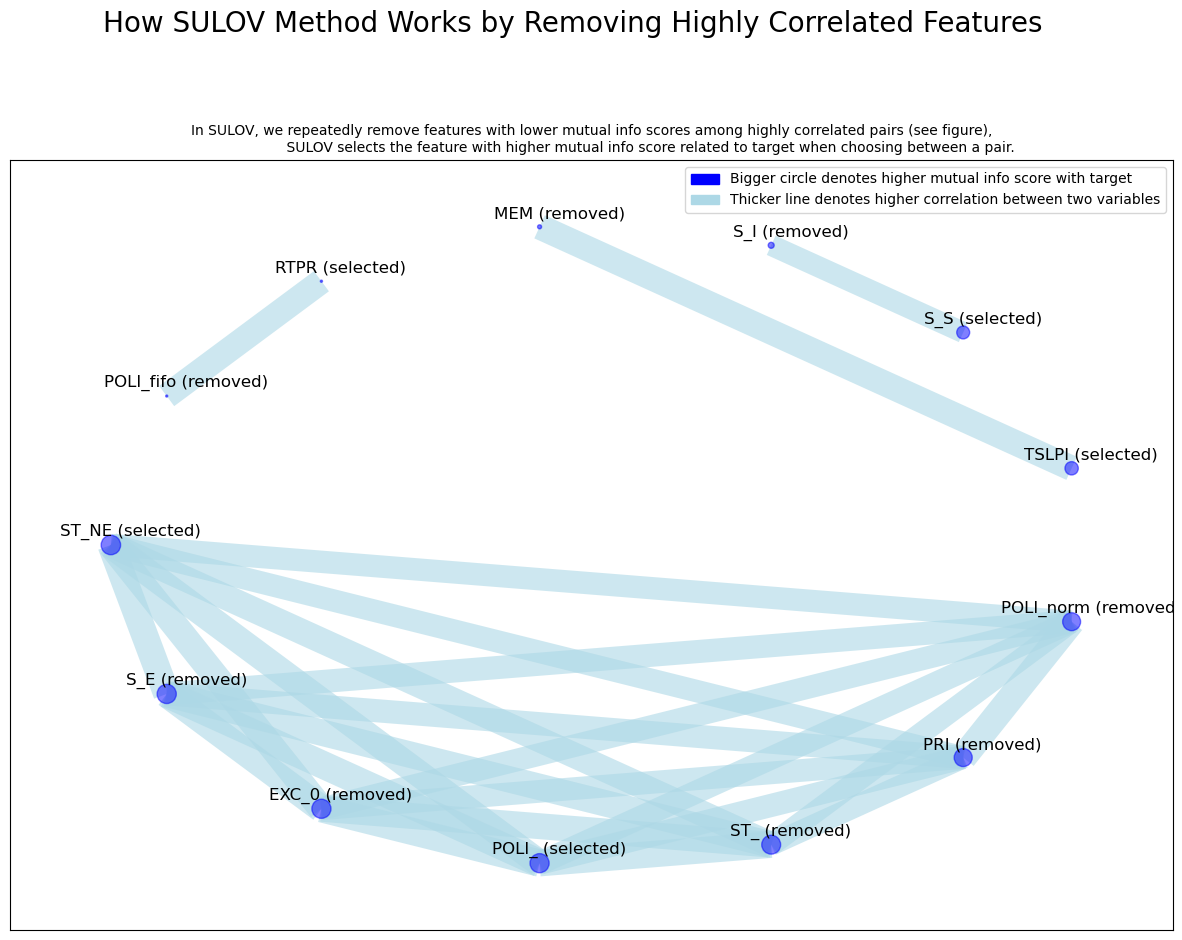

Time taken for SULOV method = 1 seconds
    Adding 0 categorical variables to reduced numeric variables  of 33
Finally 33 vars selected after SULOV
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Current number of predictors before recursive XGBoost = 33 
    Taking top 10 features per iteration...
    XGBoost version using 1.7.4 as tree method: hist
Number of booster rounds = 20
        using 33 variables...
            selecting 12 features in this iteration
            Time taken for regular XGBoost feature selection = 60 seconds
        using 26 variables...
            selecting 8 features in this iteration
            Time taken for regular XGBoost feature selection = 52 seconds


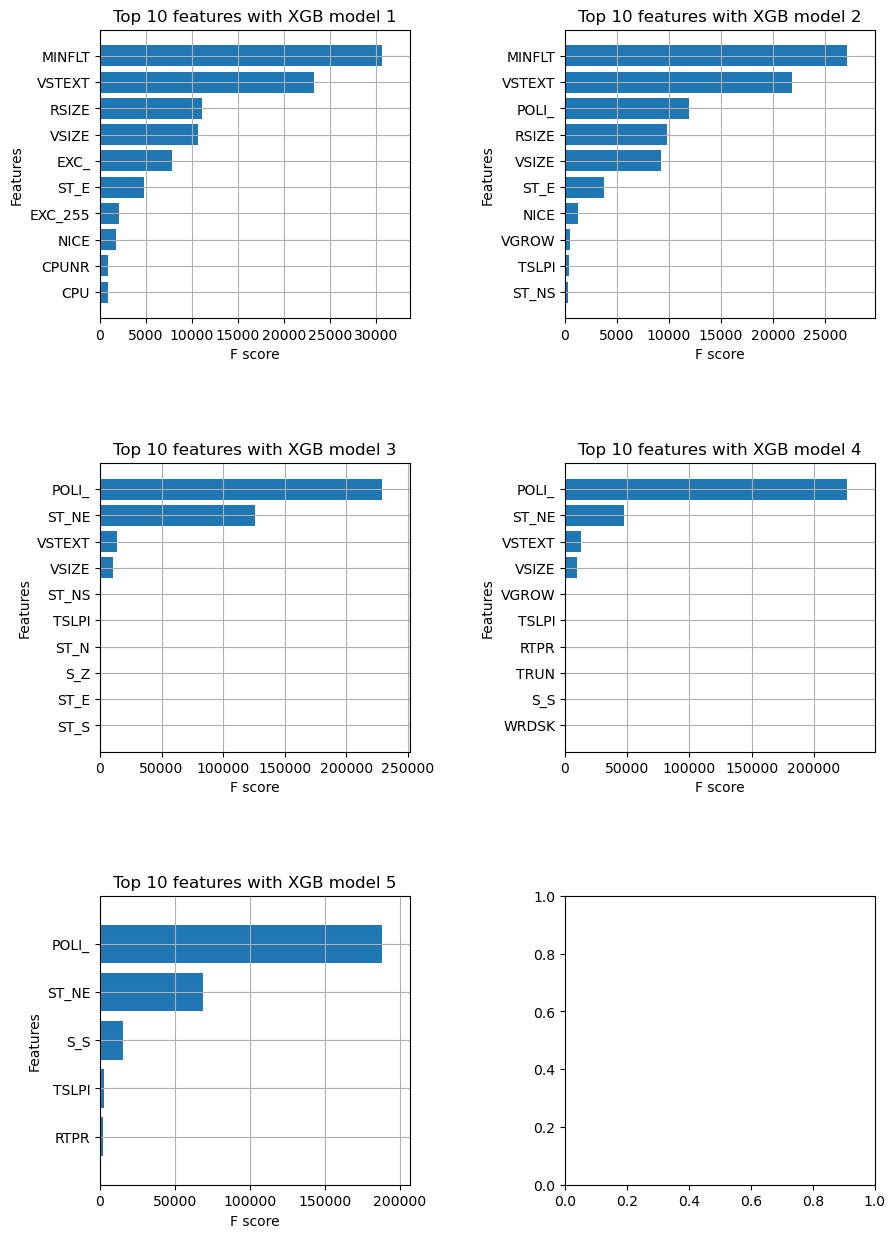

    Completed XGBoost feature selection in 40 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 17 important features:
['MINFLT', 'VSTEXT', 'RSIZE', 'VSIZE', 'EXC_', 'ST_E', 'EXC_255', 'NICE', 'CPUNR', 'CPU', 'TSLPI', 'TRUN', 'POLI_', 'VGROW', 'ST_NE', 'ST_NS', 'ST_N']
Total Time taken for featurewiz selection = 253 seconds
Output contains a list of 17 important features and a train dataframe
['MINFLT', 'VSTEXT', 'RSIZE', 'VSIZE', 'EXC_-', 'ST_-E', 'EXC_255', 'NICE', 'CPUNR', 'CPU', 'TSLPI', 'TRUN', 'POLI_-', 'VGROW', 'ST_NE', 'ST_NS', 'ST_N-']


In [10]:
one_hot_col_list = ['POLI', 'ST', 'EXC', 'S']
replace_strings = {'%': '', 'K': '000', 'M': '000000', 'G': '000000000'}
remove_rows_with_str = {'-': '0'}

df = pd.read_csv(os.path.join(folder, filename_label), low_memory=False)

del_cols = ['TIMESTAMP', 'Label']

df = df.drop(columns=del_cols)

# one-hot encoding
# df = pd.get_dummies(df, columns=one_hot_col_list)

# string replacement
for old_value, new_value in replace_strings.items():
    df = df.replace(to_replace=old_value, value=new_value, regex=True)
for old_value, new_value in remove_rows_with_str.items():
    df = df.replace(to_replace=old_value, value=new_value)

# turn to number
for k in list(df):
    df[k] = pd.to_numeric(df[k], errors='ignore')


# removing unused features from dataset
target = "Label_lifecycle"

feature, train = featurewiz(df, target, corr_limit=0.7, verbose=2, sep=",", header=0, test_data="", feature_engg="", category_encoders="")
df = train
print(feature)
output_filename = os.path.join(folder, filename_ready)
df.to_csv(output_filename, encoding='UTF-8', index=False)


3. Training preparation

In [9]:

from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, QuantileTransformer, PowerTransformer

df = pd.read_csv(os.path.join(folder, filename_ready))

max_threshold = 300000
min_threshold = 50000

print("origin data number: {0}".format(len(df.index)))
print("origin features: {0}".format(len(df.columns)-1))


for label in df['Label_lifecycle'].unique():
    # if too much, try drop duplicated first
    print(len(df[df['Label_lifecycle'] == label]))
    if len(df[df['Label_lifecycle'] == label]) > max_threshold:
        df_tmp = df.loc[df['Label_lifecycle'] == label].copy()
        df_tmp.drop_duplicates(keep='last', inplace=True)
        df.drop(df[df['Label_lifecycle'] == label].index, inplace=True)
        df = pd.concat([df, df_tmp])
        
    # # if still too much, randomly picking some of them
    # if len(df[df['Label_lifecycle'] == label]) > max_threshold:
    #     df_tmp = df.loc[df['Label_lifecycle'] == label].copy()
    #     df_tmp = df_tmp.sample(n=max_threshold, random_state=47)
    #     df.drop(df[df['Label_lifecycle'] == label].index, inplace=True)
    #     df = pd.concat([df, df_tmp])

    # if too few, double their number until it's enough
    while len(df[df['Label_lifecycle'] == label]) < min_threshold:
        tmp_df = df[df['Label_lifecycle'] == label]
        df = pd.concat([df, tmp_df])


# feature scaling
y_tmp = df['Label_lifecycle']
df.drop(columns=['Label_lifecycle'], inplace=True)
for feature in df.columns.values:
    scaler = StandardScaler().fit(df[feature].values.reshape(-1, 1))
    df[feature] = scaler.transform(df[feature].values.reshape(-1, 1))
df = pd.concat([df, y_tmp], axis=1)


print("remain data number: {0}".format(len(df.index)))
print("remain features: {0}".format(len(df.columns)-1))

output_file = os.path.join(folder, filename_train)
df.to_csv(output_file, encoding='utf-8', index=False)


origin data number: 4583180
origin features: 17
4393079
45469
37213
37368
37571
32480
remain data number: 438944
remain features: 17


4. Training and testing

In [10]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import pickle
import time
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import math

models_folder = "model_accounting_300"

df = pd.read_csv(os.path.join(folder, filename_train))

#labelings map
label_origin = sorted([int(i) for i in df['Label_lifecycle'].unique()])
le = preprocessing.LabelEncoder()
le.fit(df['Label_lifecycle'])
le_origin_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
origin_le_mapping = dict(zip(le.transform(le.classes_), le.classes_))

X = df.drop(columns=['Label_lifecycle'])
X = X.to_numpy()
# X = X.reshape(-1)
y = df['Label_lifecycle']
y = y.to_numpy()
y = y.reshape(-1)
y = le.transform(y)


#ML training
## Define ML model
core = -1

models = {}

### Linear models
models['Logistic_Regression'] = LogisticRegression(max_iter=1500, n_jobs=core)
models['SGD'] = SGDClassifier(n_jobs=core)
models['Passive_Aggressive'] = PassiveAggressiveClassifier(n_jobs=core)
### non-linear models
models['Decision_Tree'] = DecisionTreeClassifier()
models['Extra_Tree'] = ExtraTreeClassifier()
models['Naive_Bayes'] = GaussianNB()
### models['SVM'] = SVC(kernel='rbf', gamma='auto')
models['KNN'] = KNeighborsClassifier(n_jobs=core)
### ensemble models
models['Random_Forest'] = RandomForestClassifier(n_jobs=core)
### models['Ada_Boost'] = AdaBoostClassifier()
models['Bagging'] = BaggingClassifier(n_jobs=core)
models['Extra_Trees'] = ExtraTreesClassifier(n_jobs=core)
models['Gradient_Boosting'] = GradientBoostingClassifier()
models['XGBoost'] = XGBClassifier(objective='multi:softprob', eval_metric='merror', n_jobs=core)


random_seed = 42


## training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
X_train, y_train = SMOTE(n_jobs=-1, random_state=random_seed).fit_resample(X_train, y_train)
print("original labels:{}".format(label_origin))
print("X_train:{}, y_train:{}".format(len(X_train), len(y_train)))


evaluation = {}
for name in models:
    evaluation[name] = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': []
        # 'roc_auc_score': []
    }

    
for name, model in models.items():
    start_time = time.time()
    model_filename = os.path.join(models_folder, name)
    if os.path.exists(model_filename): # load the model from disk
        model = pickle.load(open(model_filename, 'rb'))
    else:
        model.fit(X_train, y_train)
        pickle.dump(model, open(model_filename, 'wb')) # save the model to disk
    y_hat = model.predict(X_test)
    end_time = time.time()
    print("model: {} \nexecution time: {:.2f}\n".format(name, end_time - start_time))
    
    # evaluation
    evaluation[name]['accuracy'].append(accuracy_score(y_test, y_hat,))
    evaluation[name]['precision'].append(precision_score(y_test, y_hat, average='weighted',zero_division=0))
    evaluation[name]['recall'].append(recall_score(y_test, y_hat, average='weighted', zero_division=0))
    evaluation[name]['f1_score'].append(f1_score(y_test, y_hat, average='weighted', zero_division=0))
    # evaluation[name]['roc_auc_score'].append(roc_auc_score(y, model.predict_proba(X)[:,1], multi_class='ovr'))

original labels:[0, 1, 2, 3, 4, 5]
X_train:437550, y_train:437550
model: Logistic_Regression 
execution time: 155.57

model: SGD 
execution time: 1.51

model: Passive_Aggressive 
execution time: 1.45

model: Decision_Tree 
execution time: 1.08

model: Extra_Tree 
execution time: 0.31

model: Naive_Bayes 
execution time: 0.30

model: KNN 
execution time: 943.25

model: Random_Forest 
execution time: 11.20

model: Bagging 
execution time: 4.57

model: Extra_Trees 
execution time: 12.94

model: Gradient_Boosting 
execution time: 355.82

model: XGBoost 
execution time: 155.25



Visualization

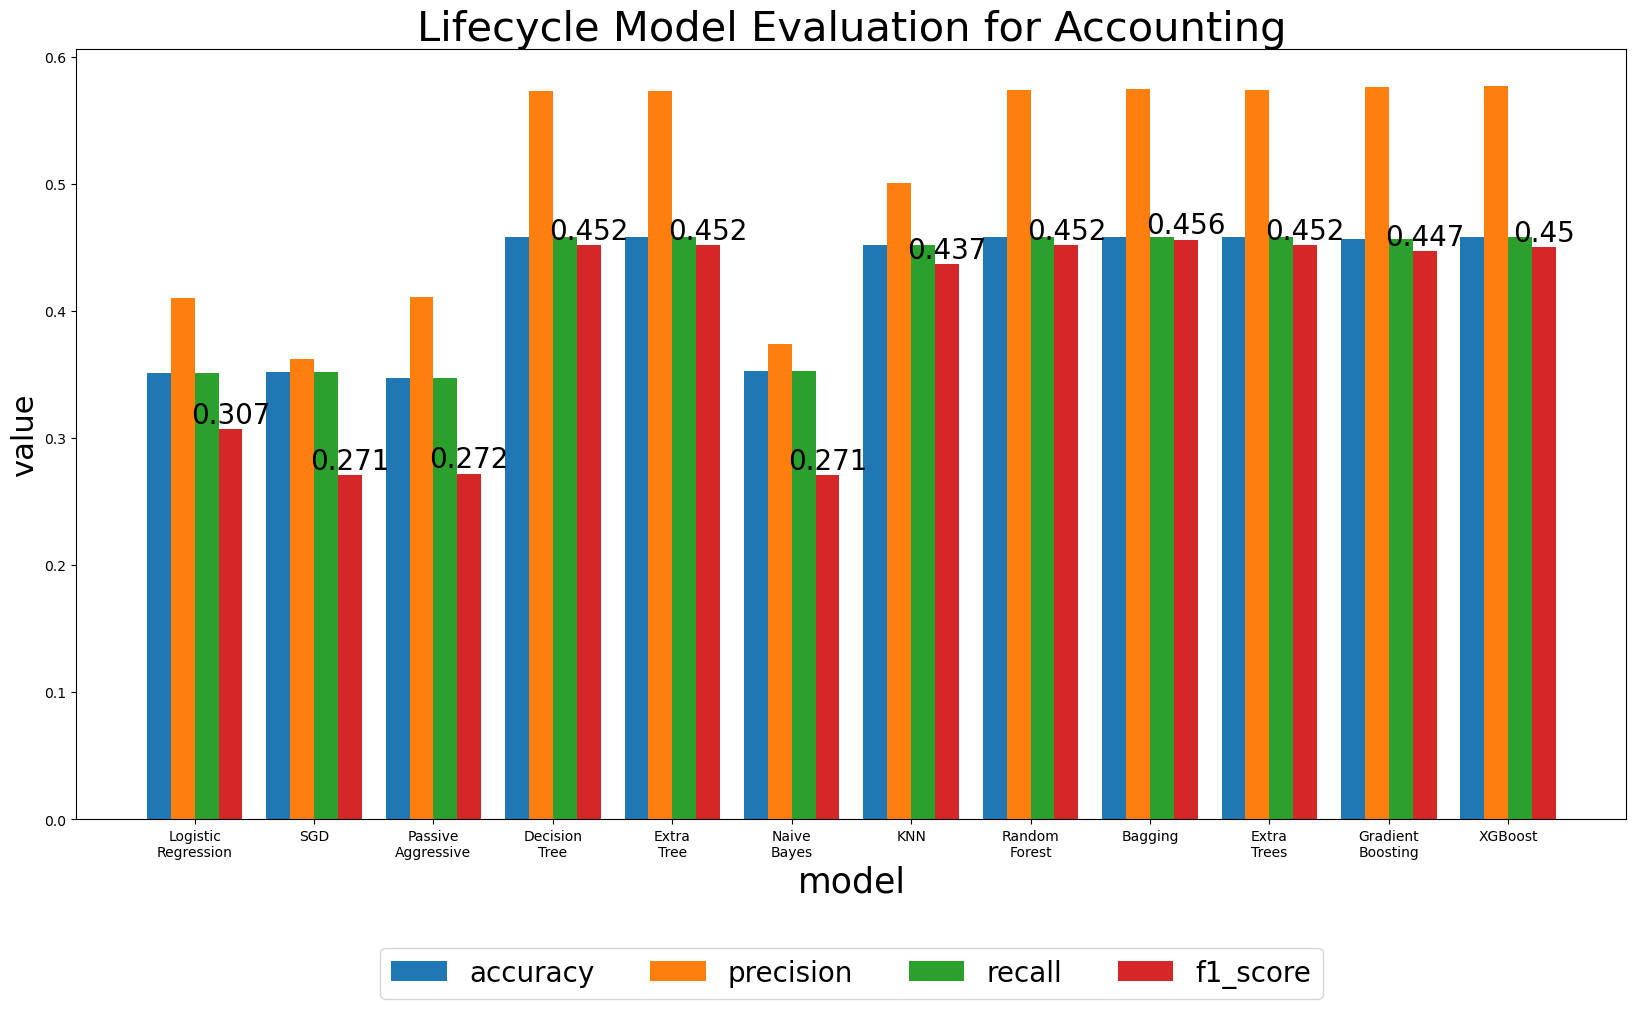

In [11]:
from statistics import mean
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import tree
import pickle

data_type = 'Accounting'

def rounded(value, n):
    return math.floor(value * (10 ** n)) / float(10 ** n) 

models = [name.replace('_', '\n') for name in evaluation]
result = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': []
}
for name in evaluation:
    for key, value in evaluation[name].items():
        result[key].append(rounded(mean(value), 3))
        
width = 0.2
x = np.arange(len(models))
plt.figure(figsize=(20, 10))
plt.bar(x, result['accuracy'], width, label='accuracy')
plt.bar(x+width, result['precision'], width, label='precision')
plt.bar(x+2*width, result['recall'], width, label='recall')
bar = plt.bar(x+3*width, result['f1_score'], width, label='f1_score')
plt.bar_label(bar, label_type='edge', fontsize=20)
plt.title('Lifecycle Model Evaluation for '+data_type, fontsize=30)
plt.xticks(x+1.5*width, models)
plt.xlabel('model', fontsize=25)
plt.ylabel('value', fontsize=22)
plt.rcParams.update({
    'xtick.labelsize': 14,
    'ytick.labelsize': 20,
})
plt.legend(loc='center', fontsize=20, ncol=4, bbox_to_anchor=(0.5,-0.2))
plt.show()





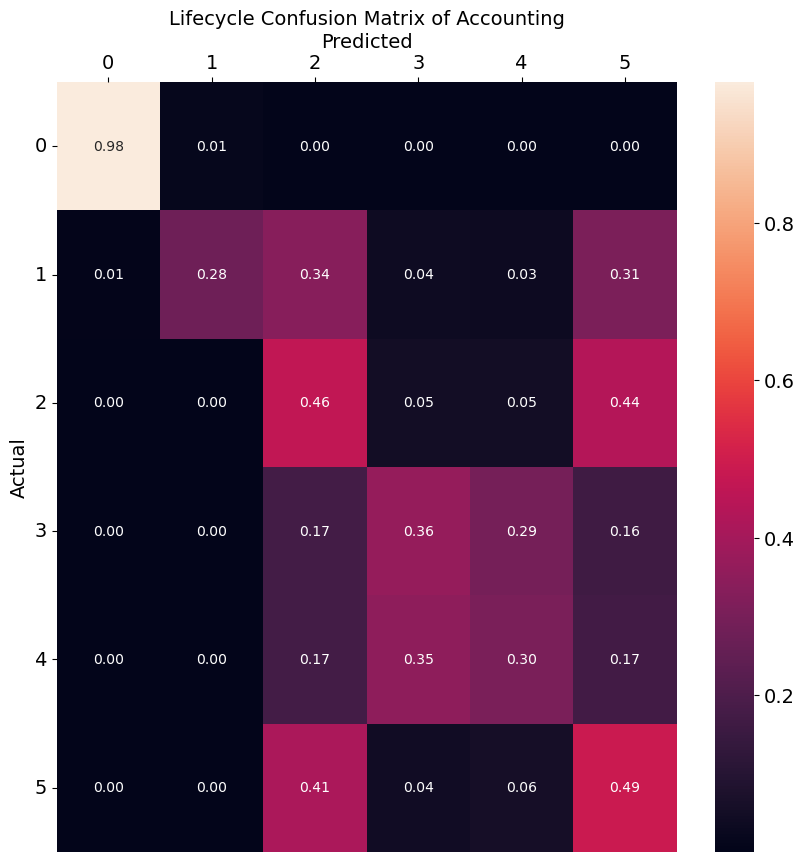

In [20]:
name = 'Extra_Trees'
model_filename = os.path.join(models_folder, name)
title = "Lifecycle Confusion Matrix of {}".format(data_type)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
target_names = label_origin
# model = tf.keras.models.load_model(model_filename)
model = pickle.load(open(model_filename, 'rb'))
y_hat = model.predict(X_test)
# y_hat = np.argmax(y_hat, axis=1)

cm = confusion_matrix(y_test, y_hat)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
# ax.xaxis.tick_top()
# ax.xaxis.set_label_position['top']
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
plt.title(title, fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.xlabel('Predicted', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show(block=False)

# tree.export_graphviz(model)

In [17]:
import json

with open(os.path.join(models_folder, 'evaluation result.json'), 'w') as file:
    file.write(json.dumps(evaluation))
print(evaluation)

{'Logistic_Regression': {'accuracy': [0.3481489919125185], 'precision': [0.42683993128833647], 'recall': [0.3481489919125185], 'f1_score': [0.3018465130863985]}, 'SGD': {'accuracy': [0.34516459733454835], 'precision': [0.3253072418008953], 'recall': [0.34516459733454835], 'f1_score': [0.2644354752211674]}, 'Passive_Aggressive': {'accuracy': [0.3499487413145005], 'precision': [0.30594035292110844], 'recall': [0.3499487413145005], 'f1_score': [0.2696023482855111]}, 'Decision_Tree': {'accuracy': [0.4533545961954665], 'precision': [0.5614213614766008], 'recall': [0.4533545961954665], 'f1_score': [0.4599502887732008]}, 'Extra_Tree': {'accuracy': [0.4533545961954665], 'precision': [0.5614720047652961], 'recall': [0.4533545961954665], 'f1_score': [0.45998368404996326]}, 'Naive_Bayes': {'accuracy': [0.3547784485704522], 'precision': [0.44032907764167206], 'recall': [0.3547784485704522], 'f1_score': [0.2724571808874405]}, 'KNN': {'accuracy': [0.43918441735960817], 'precision': [0.55857517667455